# k-Nearest Neighbor (kNN) exercise 3 - MNIST Dataset

## Students
- Flavia Pittet
- Fabio Vitali

Data source: https://drive.google.com/file/d/1UYmgX90Gv4a_rcdMDw2So_tKaxcAp-A4/view?usp=sharing

*Complete and hand in this completed worksheet.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- In this exercise, the ultimate goal is to find an optimal value of hyper-parameter k through a cross-validation procedure.

In this exercise you will implement these steps and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.
# we will be using the MNIST dataset from zalando https://github.com/zalandoresearch/fashion-mnist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window. Also setting some parameters for display.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
# This is a method to read the MNIST dataset from a ROOT directory
def load_MNIST(ROOT):
  '''load all of mnist
  training set first'''
  Xtr = []
  train = pd.read_csv(os.path.join(ROOT, 'fashion-mnist_train.csv'))
  X = np.array(train.drop('label', axis=1))
  Ytr = np.array(train['label'])
  # With this for-loop we give the data a shape of the actual image (28x28)
  # instead of the shape in file (1x784)
  for row in X:
      Xtr.append(row.reshape(28,28))
  # load test set second
  Xte = []
  test = pd.read_csv(os.path.join(ROOT, 'fashion-mnist_test.csv'))
  X = np.array(test.drop('label', axis=1))
  Yte = np.array(test['label'])
  # same reshaping
  for row in X:
      Xte.append(row.reshape(28,28))
  
  return np.array(Xtr), np.array(Ytr), np.array(Xte), np.array(Yte)


In [3]:
# Load the raw MNIST data.
mnist_dir = './data/'   # TODO: Fabio to update
X_train, y_train, X_test, y_test = load_MNIST(mnist_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


**Inline Question #1:** Notice the outputs of the shape attributes for the numpy arrays downloaded.

- What are the ranks of the arrays for the training data and test data? What do you mean by "ranks". we have the 3 dimensions, the amount of pictures, the pixels for the y and x axis.
- Are the shapes coherent from the description of the dataset that we can find [here](http://yann.lecun.com/exdb/mnist/)? Explain the different dimensions of the 4 arrays in cell above.
We don't have the same dataset, but we do have 60000 pictures, 28 by 28 pixels each for the training set, and 10000 for the test set. Both of these sets have the same amount of labels.

**Your Answer**: *fill this in.*

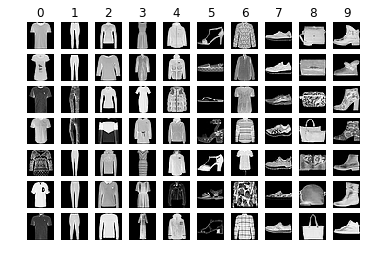

In [4]:
# Now let's visualise some of the images
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes): # y and cls takes values from 0-9
    idxs = np.flatnonzero(y_train == y) # gets the indices of samples that corresponds to class y
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # picks randomly samples_per_class indices
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1   # determines the sub-plot index
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise. We do this to make it go faster. 
# When you will have completed the whole notebook, you can run it again on a larger (or total) dataset 
# and observe the difference in terms of accuracy (and speedup).
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# TODO: sanity check: write code to print out the size of the subsampled training and test data.
print('Subsampled training data shape: ', X_train.shape)
print('Subsampled training labels shape: ', y_train.shape)
print('Subsampled test data shape: ', X_test.shape)
print('Subsampled test labels shape: ', y_test.shape)


Subsampled training data shape:  (5000, 28, 28)
Subsampled training labels shape:  (5000,)
Subsampled test data shape:  (500, 28, 28)
Subsampled test labels shape:  (500,)


In [6]:
# Shape the images vectors
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # when reshaping, -1 means "infer target dims from orig dims
X_test = np.reshape(X_test, (X_test.shape[0], -1))    # in this case it flattens the (28,28,3) into 3072 
print(X_train.shape, X_test.shape)

(5000, 784) (500, 784)


**Inline Question #2:** Notice the use of np.reshape to transform images into vectors.

- What is the effect of -1 in the reshape command?
- Are the shapes coherent from this vectorization? Explain.

**Your Answer**:

- reshape : -1 means that the value is inferred from the length of the array and remaining dimensions
- Yes, they will allow us to loop correctly over the data

In [7]:
import numpy as np

class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)
# why do we need 3 methods to implement the compute distance ? is it to show us how to optimise our code and reduce compute time ?
# If so, it took us a while to figure this out and then to code it. this needs to be made more obvious because we
# felt like we were missing something.
  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0] #number of lines, tests to do
    print(num_test)
    num_train = self.X_train.shape[0] #number of elems in training set, loaded before in training method
    print(num_train)
    dists = np.zeros((num_test, num_train)) #result, for now, with only zeros, 2 D
    for i in range(num_test):
      for j in range(num_train):        
        # We get the k nearest points and get their index
        #k_points = dists.iloc[0:k]
        #index_min_array = k_points.index

        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension.                                    #
        #####################################################################
        test = (self.X_train[j,:] - X[i,:])**2 #dist between je element and ie squared
        dists[i,j] = test.sum(axis=0)**(1/2) # Sum the vector and compute the sqrt of the result
    return dists
    
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
       

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        #TODO from ex 2's code
        dists[i,:] = (self.inputs - test_inputs.loc[i,:])**2
            
        dists[i,:] = dists[i,:].sum('columns')**(1/2) # Sum the columns for each row and compute the sqrt of the result
        dists[i,:] = dists[i,:].sort_values()
            
        # We get the k nearest points and get their index
        k_points = dists.iloc[0:k]
        index_min_array = k_points.index
            
        # We compute the mean value of the nearest labels, if it's greater than 0.5, then the predicted value is 1, otherwise it's 0
        yPred[i] = 1 if self.outputs[index_min_array].mean() > 0.5 else 0
            
      #######################################################################
      # TODO:                                                               #
      # Compute the l2 distance between the ith test point and all training #
      # points, and store the result in dists[i, :].                        #
      #######################################################################
        test[i,:] = (self.X_train - X[i,:])**2 #dist between je element and ie squared
        
        dists[i,:] = test[i,:].sum(axis='columns')**(1/2)
        
    return dists
    
      #######################################################################
      #                         END OF YOUR CODE                            #
      #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy.                #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################
    pass

    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []
      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
      
      index = dists[i,:].argsort()[:k] # argsort returns the sorted neighbors index. We get the k-th first of them 
      #closest_y.append(self.y_train[index]) # Push the corresponding label
      for ind in index:
            closest_y.append(self.y_train[ind])
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      #########################################################################
      occurences = np.zeros(index) # create 
        
      for label in closest_y:
        occurences[label] += 1
        
      y_pred[i]  = occurences.argsort()[0] # Because the index are the labels and get the first one
      
      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred

In [8]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [9]:
# TODO: implement compute_distances_two_loops from the knn class definition above

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists[1,:])

500
5000
[3755.17190019 3293.52668123 3308.65879172 ... 2538.69769764 1772.28270882
 2473.53350493]


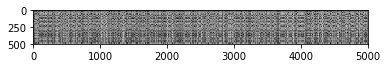

In [10]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #3:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the bright columns?

**Your Answer**: *fill this in.*



In [11]:
# TODO : Now implement the function predict_labels from the KNN class above and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (int(num_correct), num_test, accuracy))

IndexError: index 9 is out of bounds for axis 0 with size 1

You should expect to see approximately `90%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (int(num_correct), num_test, accuracy))

You should expect to see a slightly better performance than with `k = 1`.

In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [12]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50]

#X_train_folds = []
#y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k_val in k_choices:
    k_to_accuracies[k_val] = [] 
    for fold in range(num_folds):
        x_train_temp = X_train_folds #copy te array
        np.delete(x_train_temp, fold, axis=0) # delete the fold-th element
        x_train_temp = np.concatenate(x_train_temp ) #concat the other fold
        classifier.train(X_train_folds[fold], y_train_folds[fold])
        y_pred = classifier.predict(X_train_folds[fold], k=k_val)
        k_to_accuracies[k_val].append(y_pred)
        
    

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

IndexError: index 2 is out of bounds for axis 0 with size 0

In [ ]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 90% accuracy on the test data.
best_k = 1   # TODO: put your best k value here

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (int(num_correct), num_test, accuracy))